In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
seed = 42
no_users = 80
lambda_logistic = 1e-3

In [3]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [4]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [5]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    bAw = b * (A @ w)
    temp = 1. / (1. + np.exp(bAw))
    res = -(A.T @ (b * temp))/m + l2 * w
    return res

In [6]:
def hessian(w, A, b, l2):
    bAw = b * (A @ w)
    activation = scipy.special.expit(bAw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [7]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        if nx.algorithms.components.is_connected(g):
            return g

In [8]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [9]:
def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W

In [10]:
G = generate_graph(no_users, seed)

adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())
#nx.draw(G, with_labels=True, font_weight='bold')

1242
80


In [11]:
theta_opt = np.load('x_opt.npy')

In [12]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [13]:
X, y = random_split(X, y, no_users, seed)

theta = [np.zeros(num_feature) for _ in range(no_users)]


d = [np.zeros(num_feature) for _ in range(no_users)] # direction
lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

In [14]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.333347206075705 # a9a dataset

In [15]:
n_iters = 200
alpha = 0.1

losses_dsgd = []
re_dsgd = np.zeros(shape=[n_iters])
theta0 = np.zeros(num_feature)
op_gap_dsgd = np.zeros(shape=[n_iters])


for k in range(n_iters):
    
    for i in range(no_users):        
        grad = gradient(theta[i], X[i], y[i], lambda_logistic)
  
        w_neighbors_sum = np.zeros(num_feature)
        w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,i]*theta[i])
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,j]*theta[j])
        
        theta[i] = w_neighbors_sum - alpha*grad
  

    theta_avg = 1/no_users*sum(theta)
    loss_dsgd = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
    losses_dsgd.append(loss_dsgd)
    print(np.abs(losses_dsgd[-1] - obj0))
    op_gap_dsgd[k] = np.abs(losses_dsgd[-1] - obj0)
    re_dsgd[k] = np.linalg.norm(theta_avg-theta_opt)/np.linalg.norm(theta0-theta_opt)

0.2947486723485331
0.250639691336459
0.22395802247729624
0.20667907526069806
0.19436653966341588
0.1848259461933146
0.17693601666776893
0.1700980322470751
0.16397923309488643
0.1583873318738856
0.15320661792593282
0.14836426621846788
0.14381205560783833
0.13951621529268593
0.13545167853441542
0.13159877958106309
0.127941328831074
0.12446547606189695
0.12115902897219588
0.11801103691730053
0.11501153013083676
0.11215135067992421
0.10942203793228622
0.10681574674259087
0.10432518558070225
0.10194356710569868
0.09966456678498664
0.09748228696999328
0.09539122489774277
0.09338624370239806
0.09146254587610281
0.0896156488223866
0.08784136226170658
0.08613576731475525
0.08449519712676917
0.08291621891784895
0.08139561735746559
0.079930379169948
0.07851767888407363
0.0771548656450951
0.07583945101225847
0.07456909766936726
0.0733416089803437
0.07215491932604967
0.07100708516285092
0.0698962767475017
0.0688207704768668
0.06777894179477018
0.06676925862182459
0.06579027526747305
0.0648406267866

# Optimality Gap

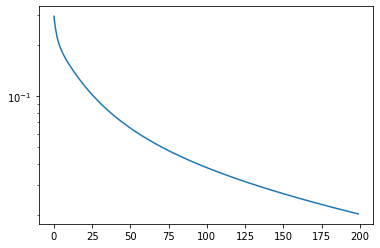

In [16]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_dsgd)
np.save('op_gap_dsgd', op_gap_dsgd)

In [17]:
theta_opt[10]

-0.12634904125482843

In [18]:
theta_avg[10]

-0.031046100238901482